In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

dataset = pd.read_csv(
    "C:/Users/ganes/OneDrive/Documents/GitHub/Project_LISA/water irrigation/datasets/2022_soil_weather_upgraded_data.csv"
)

dataset = dataset.dropna()


dataset.drop(
    [
        "Date",
        "Time",
    ],
    axis=1,
    inplace=True,
)

X = dataset.iloc[:, 1:].values
y = dataset.iloc[:, 0].values

""" taking care of categorical data in conditions column """
ct = ColumnTransformer(
    transformers=[("encoder", OneHotEncoder(), [-1])], remainder="passthrough"
)
X = np.array(ct.fit_transform(X))
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=0
)

""" Scaling data """
sc = MinMaxScaler()
X_train[:, 9:] = sc.fit_transform(X_train[:, 9:])
X_test[:, 9:] = sc.transform(X_test[:, 9:])

X_train = np.asarray(X_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
X_test = np.asarray(X_train).astype(np.float32)
y_test = np.asarray(y_train).astype(np.float32)

In [3]:
X_train[0]

array([0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00358423,
       0.90459365, 0.9559387 , 0.4968922 , 0.        , 0.19302325,
       0.852     ], dtype=float32)


Epoch 1/100


233/233 [==============================] - 2s 2ms/step - loss: 292.5963 - mean_absolute_error: 12.5798 - val_loss: 14.3569 - val_mean_absolute_error: 3.1659
Epoch 2/100
233/233 [==============================] - 0s 2ms/step - loss: 4.9405 - mean_absolute_error: 1.6372 - val_loss: 2.0150 - val_mean_absolute_error: 0.9560
Epoch 3/100
233/233 [==============================] - 0s 2ms/step - loss: 1.5532 - mean_absolute_error: 0.7581 - val_loss: 1.2681 - val_mean_absolute_error: 0.6030
Epoch 4/100
233/233 [==============================] - 0s 2ms/step - loss: 1.2294 - mean_absolute_error: 0.5702 - val_loss: 1.1575 - val_mean_absolute_error: 0.5329
Epoch 5/100
233/233 [==============================] - 0s 2ms/step - loss: 1.1402 - mean_absolute_error: 0.5005 - val_loss: 1.1691 - val_mean_absolute_error: 0.5098
Epoch 6/100
233/233 [==============================] - 0s 2ms/step - loss: 1.1239 - mean_absolute_error: 0.5005 - val_loss: 1.0759 - val_mean_absolute_error: 0.4347
Epo

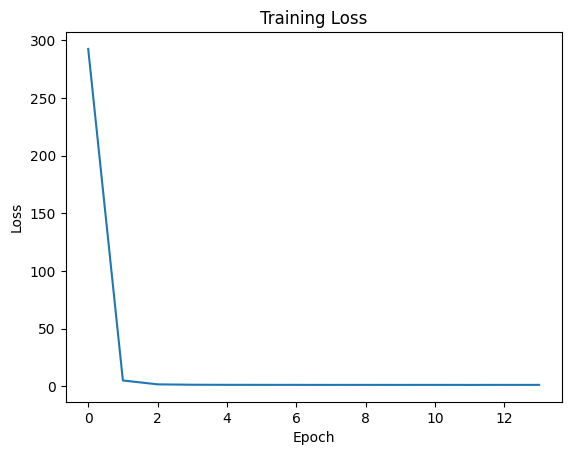

In [4]:
""" Model """
ANN_model = keras.Sequential(
    [
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dense(16, activation="relu"),
        keras.layers.Dense(8, activation="relu"),
        keras.layers.Dense(4, activation="relu"),
        keras.layers.Dense(2, activation="relu"),
        keras.layers.Dense(1),
    ]
)

ANN_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.mean_squared_error,
    metrics=keras.metrics.mean_absolute_error,
)
early_stopping = EarlyStopping(patience=5)
history = ANN_model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
)

ANN_model.summary()

plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [5]:
ann_ypred = ANN_model.predict(X_test)

233/233 [==============================] - 0s 651us/step


In [10]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso
model = LinearRegression()
model.fit(X_train, y_train)


model_ridge = Ridge(alpha=0.1)  # Adjust alpha for regularization strength
model_ridge.fit(X_train, y_train)


param_grid = {"alpha": [0.01, 0.1, 1, 10]}  # Example grid for Ridge alpha
# 5-fold cross-validation
grid_search = GridSearchCV(Ridge(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

# 5. Evaluate Performance
# Assess the model's performance on both training and testing sets using metrics like R-squared, MSE, MAE

y_pred = model.predict(X_test)  # Or use the model from grid search
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("MSE:", mse)
print("R2:", r2)
print("MAE:", mae)

MSE: 1.1022829
R2: 0.9612087406630606
MAE: 0.42236853


In [11]:
from sklearn.svm import SVR

# Try different kernels
svr_models = [
    SVR(kernel="rbf", C=10, gamma=0.1),
    SVR(kernel="linear", C=10),
    SVR(kernel="poly", C=10, degree=3),
]

# Fine-tune hyperparameters
for model in svr_models:
    model.fit(X_train, y_train)

    svr_ypred = model.predict(X_test)

    svr_mae = mean_absolute_error(y_test, svr_ypred)
    svr_mse = mean_squared_error(y_test, svr_ypred)

    print(f"SVR {model.kernel} MAE: {svr_mae}, MSE: {svr_mse}")

SVR rbf MAE: 0.33551342243170035, MSE: 1.1439453120052412
SVR linear MAE: 0.35127640272657107, MSE: 1.2088198820227516
SVR poly MAE: 0.3232046721063491, MSE: 1.010839768863369


In [12]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Feature selection using L1 regularization
mlr_model = LinearRegression()
mlr_model.fit(X_train, y_train)

mlr_ypred = mlr_model.predict(X_test)

mlr_mae = mean_absolute_error(y_test, mlr_ypred)
mlr_mse = mean_squared_error(y_test, mlr_ypred)
print("MLR MAE:", mlr_mae)
print("MLR MSE:", mlr_mse)

# Consider adding polynomial features

poly_features = PolynomialFeatures(degree=2)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

mlr_model_poly = LinearRegression()
mlr_model_poly.fit(X_train_poly, y_train)

mlr_poly_ypred = mlr_model_poly.predict(X_test_poly)

mlr_poly_mae = mean_absolute_error(y_test, mlr_poly_ypred)
mlr_poly_mse = mean_squared_error(y_test, mlr_poly_ypred)
print("MLR with Poly Features MAE:", mlr_poly_mae)
print("MLR with Poly Features MSE:", mlr_poly_mse)

MLR MAE: 0.42236853
MLR MSE: 1.1022829
MLR with Poly Features MAE: 0.37091634
MLR with Poly Features MSE: 0.8918633


In [ ]:
plt.figure(figsize=(15, 4))

plt.subplot(141)
plt.scatter(y_test[:150], y_test[:150], color="red")
plt.scatter(y_test[:150], ann_ypred[:150], color="green")
plt.title("ANN_model")

plt.subplot(142)
plt.scatter(y_test[:150], y_test[:150], color="red")
plt.scatter(y_test[:150], dtr_ypred[:150], color="green")
plt.title("dtr_model")

plt.subplot(143)
plt.scatter(y_test[:150], y_test[:150], color="red")
plt.scatter(y_test[:150], svr_ypred[:150], color="green")
plt.title("svr_models")

plt.subplot(144)
plt.scatter(y_test[:150], y_test[:150], color="red")
plt.scatter(y_test[:150], mlr_ypred[:150], color="green")
plt.title("mlr_model")

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor()
regressor.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)


param_grid = {
    "max_depth": [3, 5, 7, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "criterion": ["squared_error", "absolute_error"],
}

grid_search = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

MSE: 0.0


In [15]:
print(best_model)

DecisionTreeRegressor(max_depth=7, min_samples_leaf=4, min_samples_split=10)


In [17]:
dtr_model = DecisionTreeRegressor(max_depth=7, min_samples_leaf=4, min_samples_split=10)
dtr_model.fit(X_train, y_train)
dtr_ypred = dtr_model.predict(X_test).reshape(-1, 1)

dtr_mae = mean_absolute_error(y_test, dtr_ypred)
dtr_mse = mean_squared_error(y_test, dtr_ypred)
dtr_r2 = r2_score(y_test, dtr_ypred)
print("mean absolute error = ", dtr_mae)
print("mean Squared error = ", dtr_mse)
print("r2 score = ", dtr_r2)

mean absolute error =  0.35348076428786024
mean Squared error =  0.7238082922452308
r2 score =  0.9745279205304441
